In [1]:
import sys
sys.path.append('..')

In [5]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
# from lib.read_data import loadData
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_train, testDatasets, expectedRulDatasets = loadData()

In [4]:
drop_col = ['setting_1', 'setting_2', 'setting_3'] 
data_clean = [data.drop(columns = drop_col) for data in data_train]

In [122]:
test_data_clean = [data.drop(columns = drop_col) for data in testDatasets]

In [110]:
df_test_full = pd.DataFrame()
for i in range(4):
    df_test_full =pd.concat([df_test_full, test_data_clean[i]])

In [136]:
test_results = pd.DataFrame()
for i in range(4):
    test_results =pd.concat([test_results, expectedRulDatasets[i]])

In [137]:
test_results['id']=test_results.index+1

In [138]:
test_results

,Expected RUL,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
243,35,244
244,131,245
245,194,246
246,112,247


In [135]:
rul_te = pd.DataFrame(df_test_full.groupby('engine')['cycle'].max()).reset_index()
rul_te.columns = ['engine', 'max']

In [141]:
rul_te.head()

,engine,max
0,1,258
1,2,153
2,3,234
3,4,208
4,5,148


In [140]:
test_results['rul_failed']=test_results['Expected RUL']+rul_te['max']
test_results.head()

ValueError: cannot reindex on an axis with duplicate labels

In [149]:
df_test_cycle = df_test_full.groupby(['engine']).agg({'cycle':'max'})
df_test_cycle.rename(columns={'cycle':'life'},inplace=True)

In [150]:
df_test_cycle

,life
engine,
1,258
2,153
3,234
4,208
5,148
...,...
255,150
256,59
257,199


In [151]:

df_test_max = df_test_full.merge(df_test_cycle,how='left',on=['engine'])
df_test_max = df_test_max[(df_test_max['cycle']==df_test_max['life'])]
df_test_max.drop(['life'],axis=1,inplace=True)
# df_test_max

In [152]:
df_test_max

,engine,cycle,Fan_inlet_temperature_R,LPC_outlet_temperature_R,HPC_outlet_temperature_R,LPT_outlet_temperature_R,Fan_inlet_Pressure_psia,bypass_duct_pressure_psia,HPC_outlet_pressure_psia,Physical_fan_speed_rpm,...,Ratio_of_fuel_flow_to_Ps30_pps_psia,Corrected_fan_speed_rpm,Corrected_core_speed_rpm,Bypass_Ratio,Burner_fuel_air_ratio,Bleed_Enthalpy,Required_fan_speed,Required_fan_conversion_speed,High_pressure_turbines_Cool_air_flow,Low_pressure_turbines_Cool_air_flow
1087,10,192,518.67,643.00,1589.50,1398.99,14.62,21.61,552.88,2388.11,...,521.82,2388.08,8141.91,8.4194,0.03,393,2388,100.00,38.79,23.2956
3359,28,158,518.67,642.86,1590.81,1405.28,14.62,21.61,553.26,2388.10,...,521.63,2388.11,8134.63,8.4564,0.03,393,2388,100.00,38.86,23.2826
3869,31,196,518.67,643.31,1598.19,1420.66,14.62,21.61,551.48,2388.18,...,519.55,2388.22,8157.84,8.5015,0.03,395,2388,100.00,38.53,23.1105
6264,49,303,518.67,643.21,1607.55,1425.30,14.62,21.61,552.00,2388.21,...,520.27,2388.22,8132.46,8.5168,0.03,396,2388,100.00,38.56,23.1167
6482,51,144,518.67,642.56,1585.08,1406.60,14.62,21.61,553.58,2388.10,...,521.25,2388.12,8127.61,8.4577,0.03,394,2388,100.00,38.77,23.3108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103892,240,204,518.67,642.75,1601.48,1416.09,14.62,21.60,563.37,2388.28,...,531.09,2388.34,8167.01,8.2797,0.03,394,2388,100.00,39.39,23.6836
104245,243,199,518.67,641.96,1583.39,1398.04,14.62,21.59,554.72,2388.04,...,522.42,2388.01,8139.47,8.3751,0.03,390,2388,100.00,39.10,23.5069
104429,244,184,491.19,607.94,1488.25,1255.52,9.35,13.66,334.72,2324.21,...,314.85,2388.39,8094.02,9.2557,0.02,364,2324,100.00,24.42,14.5261
104615,247,94,462.54,536.91,1261.67,1052.33,7.05,9.03,175.84,1915.31,...,164.60,2028.24,7878.48,10.9332,0.02,307,1915,84.93,14.21,8.4721


In [5]:
df_full = pd.DataFrame()
for i in range(4):
    df_full =pd.concat([df_full, data_clean[i]])

In [6]:
df_copy = df_full.copy()

In [143]:
# drop all but one of the highly correlated features
cor_matrix = df_copy.corr().abs()
# Create a mask for the upper triangle of the correlation matrix
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
# Select features with correlation greater than 0.95
corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

# Optional: If you want to see the correlated features
print(corr_features)
# df_copy.drop(corr_features,axis=1,inplace=True)
# df_test.drop(corr_features,axis=1,inplace=True)

['LPC_outlet_temperature_R', 'HPC_outlet_temperature_R', 'LPT_outlet_temperature_R', 'Fan_inlet_Pressure_psia', 'bypass_duct_pressure_psia', 'HPC_outlet_pressure_psia', 'Physical_core_speed_rpm', 'Engine_pressure_ratioP50_P2', 'HPC_outlet_Static_pressure_psia', 'Ratio_of_fuel_flow_to_Ps30_pps_psia', 'Bypass_Ratio', 'Bleed_Enthalpy', 'Required_fan_speed', 'Required_fan_conversion_speed', 'High_pressure_turbines_Cool_air_flow', 'Low_pressure_turbines_Cool_air_flow']


In [7]:
temp_cols = ['Fan_inlet_temperature_R', 'LPC_outlet_temperature_R', 'HPC_outlet_temperature_R', 'LPT_outlet_temperature_R']
rpm_cols = ['Physical_fan_speed_rpm', 'Physical_core_speed_rpm', 'Corrected_fan_speed_rpm', 'Corrected_core_speed_rpm']
press_cols = ['bypass_duct_pressure_psia', 'HPC_outlet_pressure_psia','Engine_pressure_ratioP50_P2', 'HPC_outlet_Static_pressure_psia']
air_flow_cols = ['High_pressure_turbines_Cool_air_flow', 'Low_pressure_turbines_Cool_air_flow']

In [8]:
df_all = df_copy #[temp_cols]

In [9]:
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('engine')['cycle'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['engine','max']
    df = df.merge(fd_RUL, on=['engine'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop(columns=['max'],inplace = True)
    return df[df['cycle'] > factor]

In [10]:
df = prepare_train_data(df_all)

Backward step-wise regression:

For each feature, check its statistical significance using the p-value. The p-value indicates the probability that the feature's coefficient is equal to zero (i.e., the feature has no effect on the target variable).



In [11]:
df.head(3)

,engine,cycle,Fan_inlet_temperature_R,LPC_outlet_temperature_R,HPC_outlet_temperature_R,LPT_outlet_temperature_R,Fan_inlet_Pressure_psia,bypass_duct_pressure_psia,HPC_outlet_pressure_psia,Physical_fan_speed_rpm,...,Corrected_fan_speed_rpm,Corrected_core_speed_rpm,Bypass_Ratio,Burner_fuel_air_ratio,Bleed_Enthalpy,Required_fan_speed,Required_fan_conversion_speed,High_pressure_turbines_Cool_air_flow,Low_pressure_turbines_Cool_air_flow,RUL
0,1,1,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,320
1,1,2,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,319
2,1,3,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,318


In [12]:
df.shape

(160359, 24)

In [13]:
Selected_Features = []

def backward_regression(X, y, initial_list=[], threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression 
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.extend(included)
    print(f"\nSelected Features:\n{Selected_Features}")
    return

In [14]:
train_end = int(len(df)*0.7)
val_end = int(len(df)*0.8)

In [15]:
df_train_x = df[[col for col in df.columns if col not in ['RUL']]].iloc[:train_end]
df_train_y = df[['RUL']].iloc[:train_end]

df_val_x = df[[col for col in df.columns if col not in ['RUL']]].iloc[train_end: val_end].reset_index(drop=True)
df_val_y = df[['RUL']].iloc[train_end: val_end].reset_index(drop=True)

df_test_x = df[[col for col in df.columns if col not in ['RUL']]].iloc[val_end:].reset_index(drop=True)
df_test_y = df[['RUL']].iloc[val_end:].reset_index(drop=True)

In [16]:
backward_regression(df_train_x, df_train_y)

worst_feature : Corrected_core_speed_rpm, 0.8704159553642903 
worst_feature : Corrected_fan_speed_rpm, 0.8146973316011976 
worst_feature : Bypass_Ratio, 0.13754392044968622 

Selected Features:
['engine', 'cycle', 'Fan_inlet_temperature_R', 'LPC_outlet_temperature_R', 'HPC_outlet_temperature_R', 'LPT_outlet_temperature_R', 'Fan_inlet_Pressure_psia', 'bypass_duct_pressure_psia', 'HPC_outlet_pressure_psia', 'Physical_fan_speed_rpm', 'Physical_core_speed_rpm', 'Engine_pressure_ratioP50_P2', 'HPC_outlet_Static_pressure_psia', 'Ratio_of_fuel_flow_to_Ps30_pps_psia', 'Burner_fuel_air_ratio', 'Bleed_Enthalpy', 'Required_fan_speed', 'Required_fan_conversion_speed', 'High_pressure_turbines_Cool_air_flow', 'Low_pressure_turbines_Cool_air_flow']


In [17]:
df_train_x = df_train_x[Selected_Features]
df_test_x = df_test_x[Selected_Features]
df_val_x = df_val_x[Selected_Features]

In [20]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

df_train_scaled = pd.DataFrame(np.concatenate([scaler_x.fit_transform(df_train_x), scaler_y.fit_transform(df_train_y)], axis = 1), columns=Selected_Features +['RUL'])
df_val_scaled = pd.DataFrame(np.concatenate([scaler_x.transform(df_val_x), scaler_y.transform(df_val_y)], axis = 1), columns= Selected_Features +['RUL'])
df_test_scaled = pd.DataFrame(np.concatenate([scaler_x.transform(df_test_x), df_test_y], axis = 1), columns= Selected_Features +['RUL'])

In [21]:
x_train, y_train = df_train_scaled[Selected_Features].values, df_train_scaled[['RUL']].values
x_test, y_test  =  df_test_scaled[Selected_Features].values, df_test_scaled[['RUL']].values

In [22]:
def evaluate(y_true, y_pred):
    print(f'MSE: {mean_squared_error(y_true, y_pred):.2f}')
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.2f}')
    print(f'r2 score: {r2_score(y_true, y_pred):.2f}')
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Create a mask for non-zero actual values
    non_zero_mask = y_true != 0

    # Ensure that there are non-zero actual values
    if not np.any(non_zero_mask):
        raise ValueError("All actual values are zero, MAPE is undefined.")

    # Calculate MAPE
    abs_percentage_error = np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])
    mape = np.mean(abs_percentage_error) * 100
    print(f'MAPE: {mape:.2f}')

In [23]:
def plot_result(y_actual, y_pred):
    plt.figure(figsize= (20, 5))
    plt.plot(y_actual, label='actual', color = 'blue')
    plt.plot(y_pred, label= 'prediction', color='orange' )
    plt.legend()
    plt.show()

Linear Regressor

In [24]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(x_train, y_train)

LinearRegression()

In [25]:
y_pred_test_lin_reg = scaler_y.inverse_transform(model_lin_reg.predict(x_test))

In [33]:
y_pred_train_lin_reg = scaler_y.inverse_transform(model_lin_reg.predict(x_train))
y_train = scaler_y.inverse_transform(y_train)

In [34]:
evaluate(y_train, y_pred_train_lin_reg)

MSE: 4740.96
MAE: 53.84
r2 score: 0.49
MAPE: 62.75


In [26]:
evaluate(y_test, y_pred_test_lin_reg)

MSE: 3508.36
MAE: 48.22
r2 score: 0.55
MAPE: 92.91


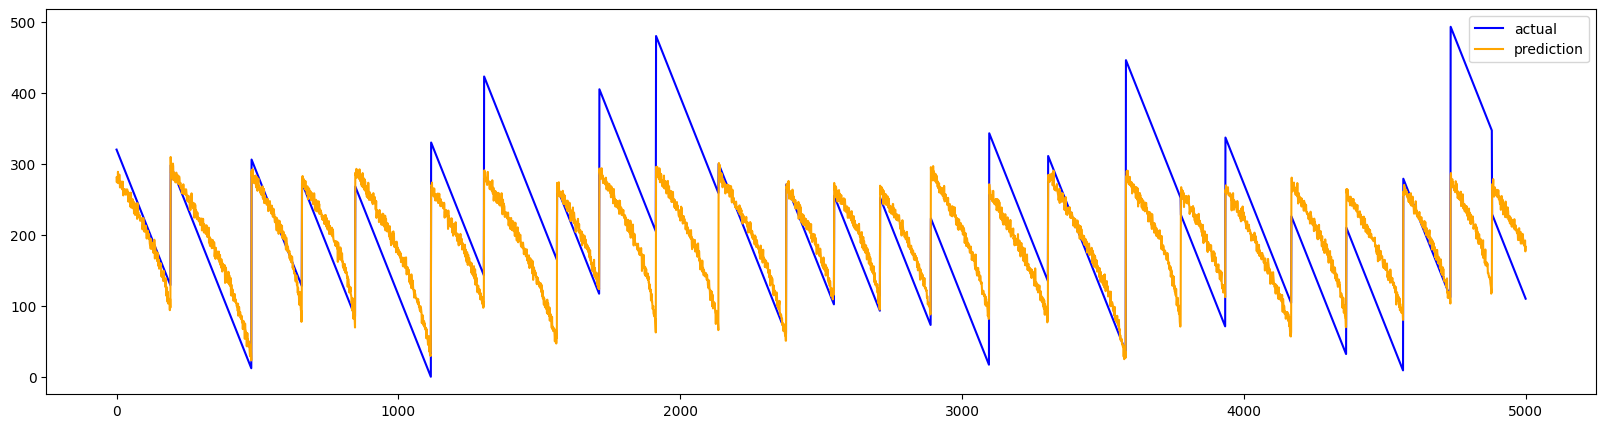

In [37]:
plot_result(y_train[:5000], y_pred_train_lin_reg[:5000])

Support vector regressor

In [26]:
from sklearn.svm import SVR
svr_model = SVR(kernel = 'rbf')
svr_model.fit(x_train, y_train)

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [27]:
y_pred_test_svr = scaler_y.inverse_transform(svr_model.predict(x_test).reshape(-1, 1))
plot_predActual(y_test, y_pred_test_svr)

MSE: 2891.51
MAE: 41.28
r2 score: 0.63
MAPE: 64.74


In [29]:
pd.DataFrame({'actual':y_test.squeeze(), 'pred': y_pred_test_svr.squeeze()})

,actual,pred
0,46.0,51.589556
1,45.0,59.944203
2,44.0,71.559410
3,43.0,68.745570
4,42.0,93.902586
...,...,...
32067,4.0,30.485012
32068,3.0,-2.982123
32069,2.0,-19.698870
32070,1.0,-3.814901


In [30]:
error = (y_test - y_pred_test_svr).flatten()

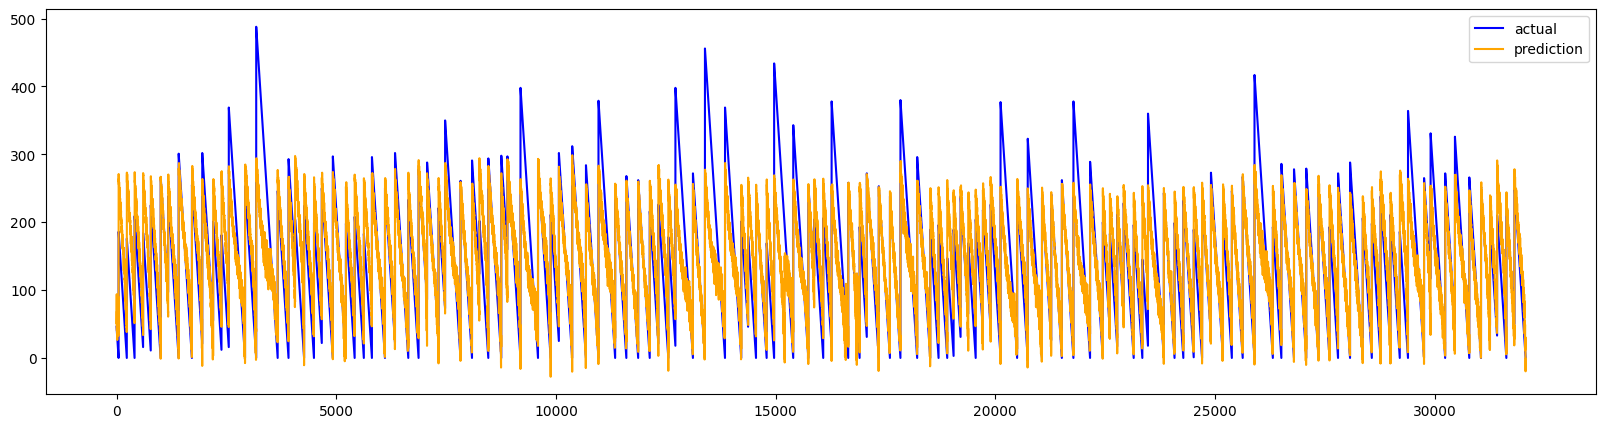

In [37]:
plot_result(y_test, y_pred_test_svr)

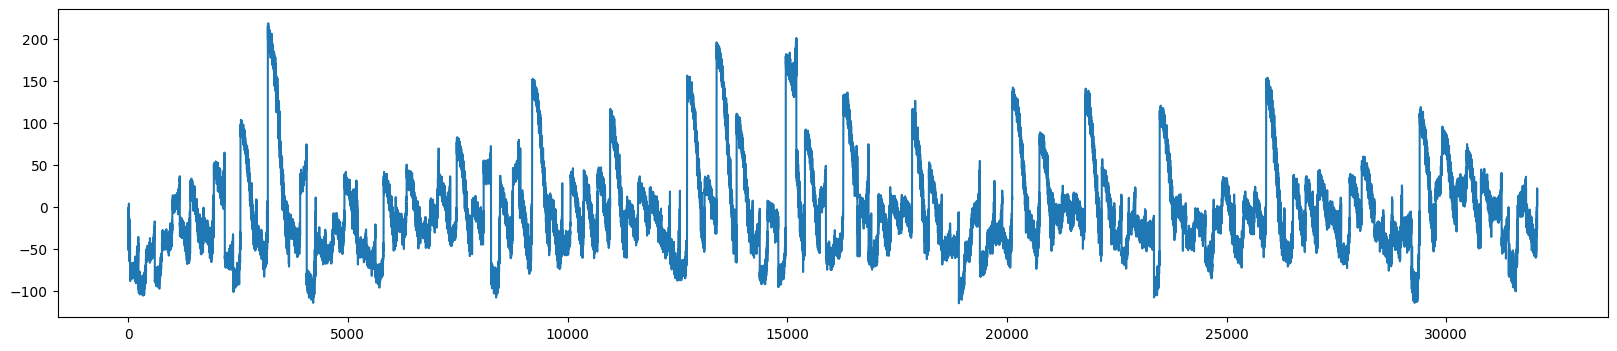

In [32]:
plt.figure(figsize=(20,4))
plt.plot(error)
plt.show()

In [103]:
error

array([ -5.58955576, -14.94420288, -27.55940984, ...,  21.69887047,
         4.81490127,   1.23854013])

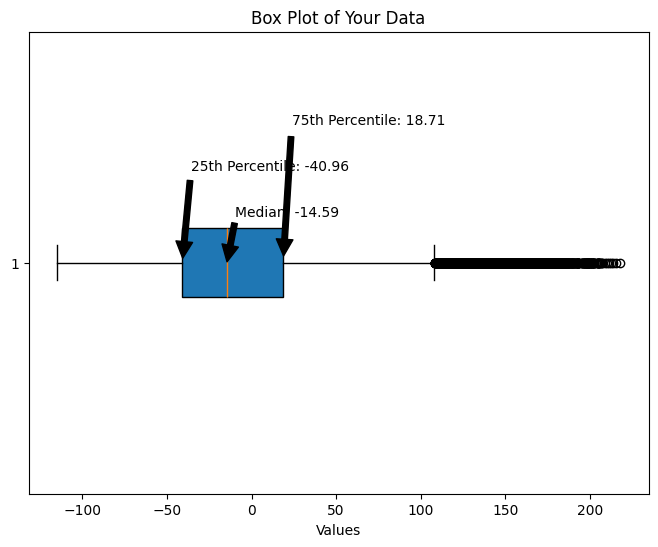

In [106]:
# Create the box plot
plt.figure(figsize=(8, 6))
box = plt.boxplot(error, vert=False, patch_artist=True)

# Extract the quantiles
median = np.median(error)
q1 = np.percentile(error, 25)
q3 = np.percentile(error, 75)
iqr = q3 - q1  # Interquartile range

# Add title and labels
plt.title('Box Plot of Your Data')
plt.xlabel('Values')

# Annotate the quantiles
plt.annotate(f'Median: {median:.2f}', xy=(median, 1), xytext=(median + 5, 1.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'25th Percentile: {q1:.2f}', xy=(q1, 1), xytext=(q1 + 5, 1.2),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'75th Percentile: {q3:.2f}', xy=(q3, 1), xytext=(q3 + 5, 1.3),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Customize box plot appearance
for median_line in box['medians']:
    plt.plot([median_line.get_xdata()[0], median_line.get_xdata()[1]], 
             [1, 1], color='black', linestyle='--')

# Show the plot
plt.show()

Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators = 100)
model_rf.fit(x_train, y_train)

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [22]:
y_pred_test_rf = scaler_y.inverse_transform(model_rf.predict(x_test).reshape(-1, 1))
plot_predActual(y_test, y_pred_test_rf)

MSE: 736.27
MAE: 14.37
r2 score: 0.91
MAPE: 64.24


gradient boost regressor

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
model_gb = GradientBoostingRegressor(n_estimators=100)
model_gb.fit(x_train, y_train)

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor()

In [43]:
y_pred_test_gb = scaler_y.inverse_transform(model_gb.predict(x_test).reshape(-1, 1))
plot_predActual(y_test, y_pred_test_gb)

MSE: 3053.91
MAE: 42.31
r2 score: 0.61
MAPE: 91.23


XGBoost

In [ ]:
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.02, gamma=0, subsample=0.8,colsample_bytree=0.5, max_depth=3)
xgb.fit(X_train_2_s, y_train_clip)

grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()
param_grid = { 
    'n_estimators': [50,90,120],
    'max_depth' : [8,9,10],
}

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3)

grid.fit(X_train_tm_s, y_train_tm)

print(grid.best_score_ , grid.best_params_)

FPCA Implementation

In [38]:
import numpy as np
import skfda
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA

C:\Users\PriyamJha\AppData\Local\Temp\ipykernel_12900\1780397162.py:3: DeprecationWarning: The module "feature_extraction" is deprecated.Please use "dim_reduction" for FPCAor "feature_construction" for feature construction techniques
  from skfda.preprocessing.dim_reduction.feature_extraction import FPCA


In [39]:
# Functional data object
fd = skfda.FDataGrid(x_train)

# Perform FPCA to reduce noise and extract principal components
fpca = FPCA(n_components=4)  # Choose the number of components
fpca.fit(fd)
reconstructed_data = fpca.transform(fd)

In [40]:
reconstructed_data.shape, x_train.shape

((112251, 4), (112251, 20))

output_length = (input_length + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1

torch.Size([64, 20, 10])

conv1: torch.Size([64, 64, 11])

conv2 torch.Size([64, 64, 12])

resid: torch.Size([64, 64, 10])

torch.Size([64, 20, 10])
conv1: torch.Size([64, 64, 10])
conv2 torch.Size([64, 64, 10])
resid: torch.Size([64, 64, 10])

conv1: torch.Size([64, 128, 10])
conv2 torch.Size([64, 128, 10])
resid: torch.Size([64, 128, 10])

conv1: torch.Size([64, 256, 10])
conv2 torch.Size([64, 256, 10])
resid: torch.Size([64, 256, 10])

In [41]:
import torch
import torch.nn as nn

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding): # (20, 64, k=2, s=1, d=1, p=d), (64, 128, k=2, s=1, d=2, p=d)
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding='same', dilation=dilation)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding='same', dilation=dilation)
        self.residual = nn.Conv1d(in_channels, out_channels, kernel_size =1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.conv1(x))
        # print('conv1:', out.shape)
        out = self.conv2(out)
        # print('conv2', out.shape)
        if self.residual:   
            x = self.residual(x)
            # print('resid:', x.shape)
        return self.relu(out + x)

class TCN(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=2):
        super(TCN, self).__init__()
        layers = []
        for i in range(len(num_channels)): # len([64, 128, 256])
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i - 1] # 20 if i ==0 else [64, 128]
            out_channels = num_channels[i] # [64, 128, 256][i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation, padding=(kernel_size-1) * dilation))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


torch.Size([64, 20, 10])
x: torch.Size([64, 256, 10])
y: torch.Size([256, 64])

In [52]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16): # 256, 16
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Conv1d(channel, channel // reduction, kernel_size=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv1d(channel // reduction, channel, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _ = x.size()
        # print('x:', x.shape)
        y = self.global_avg_pool(x).view(c, b)
        # print('y:', y.shape)
        y = y.unsqueeze(-1).permute(1, 0, 2)
        # print('y permute:', y.shape)
        # y = self.relu(self.fc1(y.unsqueeze(-1)))
        y = self.relu(self.fc1(y))
        y = self.sigmoid(self.fc2(y))
        # print('final shape', y.unsqueeze(-1).shape, x.shape)
        # return x * y.unsqueeze(-1)
        return x * y


final shape torch.Size([64, 256, 1, 1]) torch.Size([64, 256, 10])

In [53]:
class FPCASETCN(nn.Module):
    def __init__(self, input_size, tcn_channels, kernel_size=2, se_reduction=16):
        super(FPCASETCN, self).__init__()
        self.tcn = TCN(input_size, tcn_channels, kernel_size)
        self.se_block = SEBlock(tcn_channels[-1], reduction=se_reduction) # 256, 16
        self.fc = nn.Linear(tcn_channels[-1], 1)  # Output for RUL prediction

    def forward(self, x):
        tcn_out = self.tcn(x)
        se_out = self.se_block(tcn_out)
        se_out = torch.mean(se_out, dim=-1)  # Global average pooling
        return self.fc(se_out)

In [54]:
# Example training loop with batches
epochs = 10
model = FPCASETCN(input_size=x_train.shape[-1], tcn_channels=[64, 128, 256])  # Example model
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [55]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.from_numpy(x_data).float()  # Convert numpy to tensor
        self.y_data = torch.from_numpy(y_data).float()

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [56]:
x_train.shape, y_train.shape

((112251, 20), (112251, 1))

In [57]:
x_seq = []
y_seq = []
for i in range(len(x_train)-10):
    x_seq.append(x_train[i:i+10])
    y_seq.append(y_train[i+10])

In [58]:
len(x_seq), len(y_seq)

(112241, 112241)

In [59]:
# Create Dataset
train_dataset = TimeSeriesDataset(np.array(x_seq), np.array(y_seq))
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [60]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

The formula for calculating the output length of a 1D convolution is:

output_length = (input_length + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1

In [61]:
# from torchsummary import summary
# summary(model, input_size=(20, 10))  # (num_channels, sequence_length)

In [62]:
for epoch in range(epochs):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to the same device as the model
        inputs, targets = inputs.to(device), targets.to(device)
        # inputs = inputs.unsqueeze(2) 
        inputs = inputs.permute(0, 2, 1)
        # print(inputs.shape)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate loss
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\torch\nn\modules\conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch [1/10], Loss: 4793.3872
Epoch [2/10], Loss: 4761.2637
Epoch [3/10], Loss: 7018.6235
Epoch [4/10], Loss: 5060.6558
Epoch [5/10], Loss: 6418.2847
Epoch [6/10], Loss: 6159.7310
Epoch [7/10], Loss: 3845.7280
Epoch [8/10], Loss: 4963.9316
Epoch [9/10], Loss: 3978.5774
Epoch [10/10], Loss: 5230.9355


In [63]:
y_pred_fptcn = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.permute(0, 2, 1)
        outputs = model(inputs)
        y_pred_fptcn.append(outputs)

In [85]:
y_pred_fptcn = [item.item() for sublist in y_pred_fptcn for item in sublist]

In [104]:
y_pred_fptcn = [int(ele) for ele in y_pred_fptcn]

In [105]:
evaluate(y_train.squeeze()[:len(y_pred_fptcn)], y_pred_fptcn)

MSE: 13908.97
MAE: 94.52
r2 score: -0.50
MAPE: 155.18


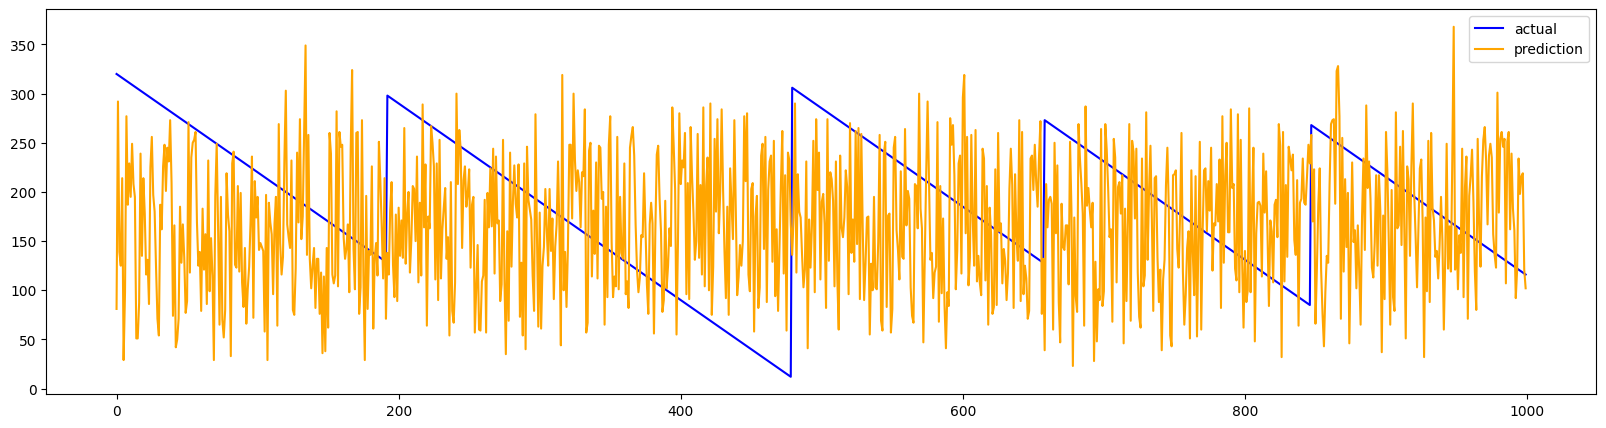

In [106]:
plot_result(y_train.squeeze()[:1000], y_pred_fptcn[:1000])